# Part 2: Pneumonia prediction dataset

In [13]:
# import the necessary libraries for doing exploration of image data and then doing prediction with a CNN (using torch)

import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, datasets, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, SubsetRandomSampler
from collections import OrderedDict
from tqdm import tqdm
pd.options.plotting.backend = "plotly"
from torch import nn, optim
from torch.autograd import Variable

from torchvision.utils import save_image
from imgaug import augmenters as iaa
from pathlib import Path
import random

import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay


from PIL import Image
# Importing Captum library for interpretability
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap



## Q1: Exploratory data analysis

In [14]:
# We first visualize some examples from the training data for each class to get an idea of what the data looks like
# and we explore the labels distribution across datasets
data_dir = '/Users/akilabeddiaf/Documents/Sophia/ETHZ/CBB/S2/ML4H/Project_1/pneumonia_prediction/chest_xray'

trainset = datasets.ImageFolder(os.path.join(data_dir, 'train'))
testset = datasets.ImageFolder(os.path.join(data_dir, 'test'))
validset = datasets.ImageFolder(os.path.join(data_dir, 'val'))

In [15]:
#The method automatically loads the images and uderstands the binary classification form the structure of the folders
class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


### Q1.1: Exploring label distribution

In [90]:
# for each dataset plot the label distribution
train_labels = [x[1] for x in trainset]
test_labels = [x[1] for x in testset]
valid_labels = [x[1] for x in validset]

train_labels_count = pd.Series(train_labels).value_counts().sort_index()
test_labels_count = pd.Series(test_labels).value_counts().sort_index()
valid_labels_count = pd.Series(valid_labels).value_counts().sort_index()

print("TRAIN LABELS:")
print(
    "# of Normal cases: ",
    train_labels_count[0],
    " # of Pneumonia cases: ",
    train_labels_count[1],
    "\n",
)
print("TEST LABELS:")
print(
    "# of Normal cases: ",
    test_labels_count[0],
    " # of Pneumonia cases: ",
    test_labels_count[1],
    "\n",
)
print("VALIDATION LABELS:")
print(
    "# of Normal cases: ",
    valid_labels_count[0],
    " # of Pneumonia cases: ",
    valid_labels_count[1],
    "\n",
)


TRAIN LABELS:
# of Normal cases:  1341  # of Pneumonia cases:  3875 

TEST LABELS:
# of Normal cases:  234  # of Pneumonia cases:  390 

VALIDATION LABELS:
# of Normal cases:  8  # of Pneumonia cases:  8 



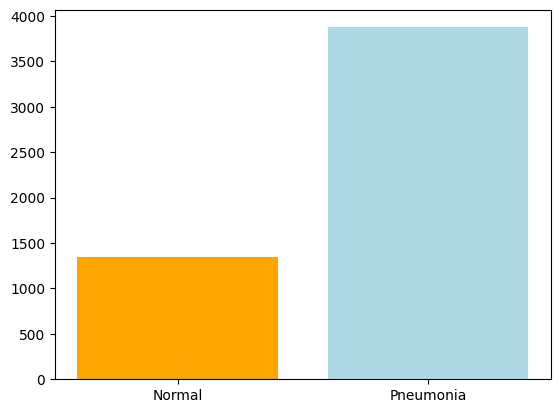

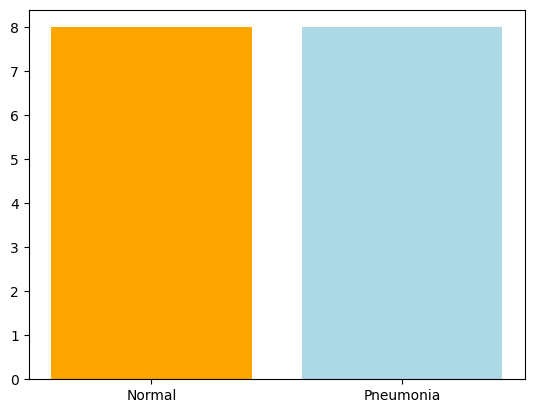

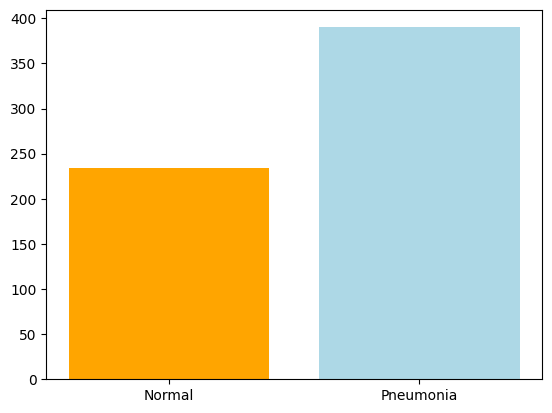

In [92]:
# Plotting the labels distribution as a bar chart
save_dir = '/Users/akilabeddiaf/Documents/Sophia/ETHZ/CBB/S2/ML4H/Project_1/pneumonia_prediction/plots/'
    # For the train set
plt.bar(['Normal', 'Pneumonia'], [train_labels_count[0], train_labels_count[1]], color=['orange','lightblue'])
#plt.title('Distribution of Training Labels')
plt.savefig(save_dir + 'train_labels_distribution.png')
plt.show()
    # For the validation set
plt.bar(['Normal', 'Pneumonia'], [valid_labels_count[0], valid_labels_count[1]], color=['orange','lightblue'])
#plt.title('Distribution of Validation Labels')
plt.savefig(save_dir + 'validation_labels_distribution.png')
plt.show()
    # For the test set
plt.bar(['Normal', 'Pneumonia'], [test_labels_count[0], test_labels_count[1]], color=['orange','lightblue'])
#plt.title('Distribution of Test Labels')
plt.savefig(save_dir + 'test_labels_distribution.png')
plt.show()

We can see that the classes are: 
- very unbalanced for the training set (just ~26% of the elements belong to the `NORMAL` class)
- quite unbalanced for the validation set (~ 38% of the element belong to the `NORMAL` classs)
- balanced for the test set (exactly 50% of the element belong to the `NORMAL` classs)

This means that we will probably need to do some data augmentation in order to have more balanced classes and therefore perform better training of our model 

### Q1.2 : Visual differences in the datset

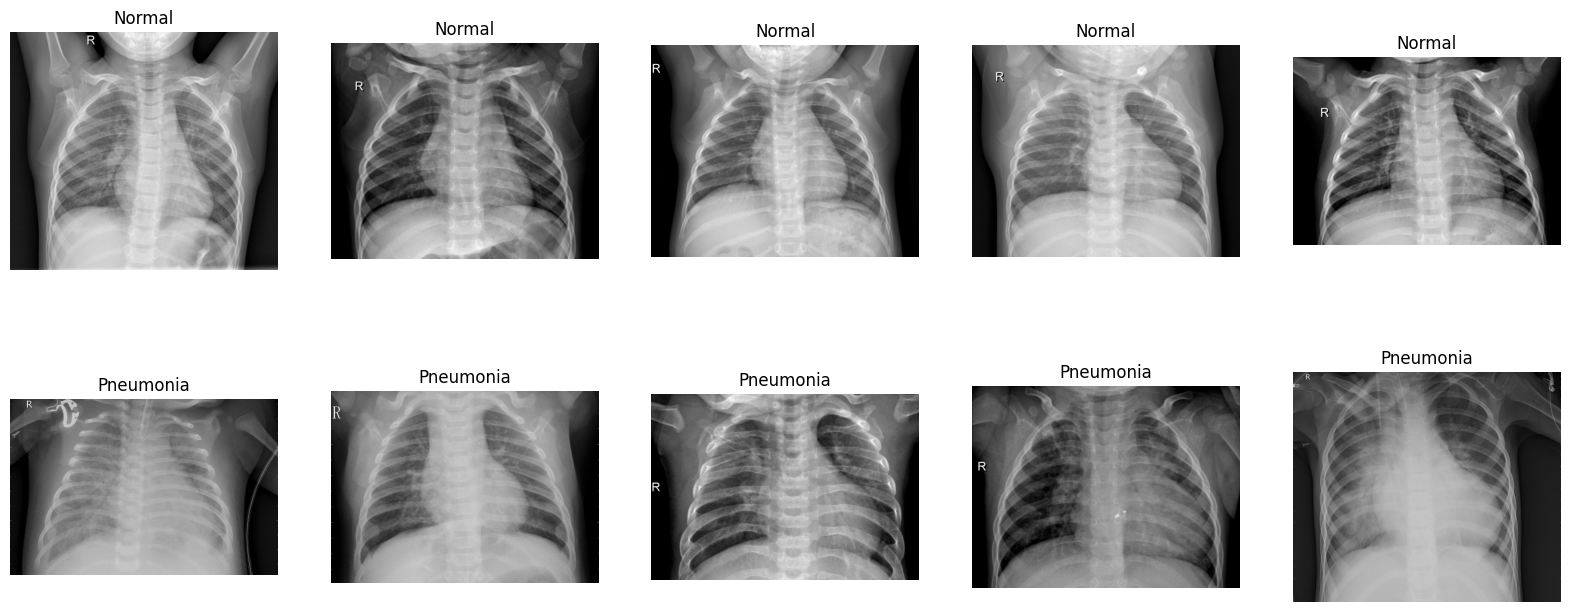

In [94]:
#visualize 5 examples of images from the penumonia label and 5 from the normal label in the training set to get an idea of what the data looks like

normal_indices = [i for i, x in enumerate(trainset.targets) if x == 0]
pneumonia_indices = [i for i, x in enumerate(trainset.targets) if x == 1]

Ex_normal = [trainset[i] for i in normal_indices[:5]]
Ex_pneumonia = [trainset[i] for i in pneumonia_indices[:5]]

#Plot the examples
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
#fig.suptitle('Pneumonia vs Normal', fontsize=20)

for i in range(5):
    # For Normal
    ax[0, i].imshow(Ex_normal[i][0])
    ax[0, i].set_title('Normal')
    ax[0, i].axis('off')
    
    # For Pneumonia
    ax[1, i].imshow(Ex_pneumonia[i][0])
    ax[1, i].set_title('Pneumonia')
    ax[1, i].axis('off')

plt.savefig(save_dir + 'Pneumonia_vs_Normal.png')
plt.show()


From the plotted images it seems that patients affected with pneumonia have the heart (the white area towards the center of the torax) less well defined in terms of contours and is more expanded towards the right side of the patient. This medically corresponds to a filling of the alveoli with infectuous material and pus

### Q1.3: Potential biases in the analysis 

Even if we underlined how some of the typical characteristics of the disease clearly manifest themselves when comparing the two classes of images, by looking through the dataset we find other elements that might mislead the classificaiton. These elements appear predominantly in one of the classes and could be lerned by the neural network even if they don't bear any causal connection with the desease, therefore introducing biases.

An example are some external elements (probably medical devices) that appear almost always in the X-rays of the pneumonia patients. Some examples are plotted here below

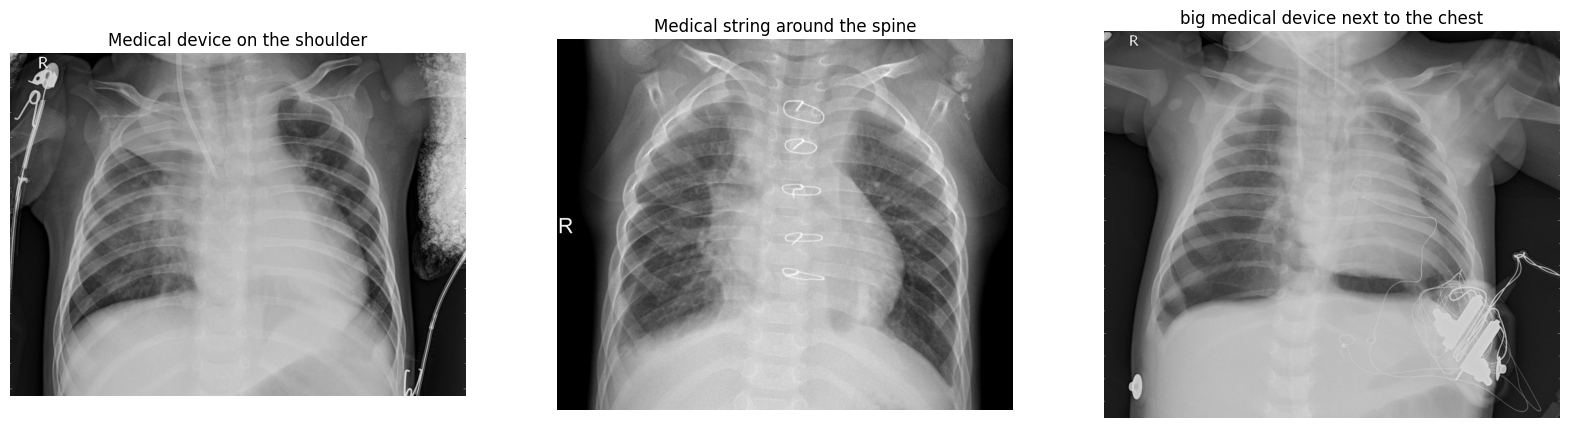

In [95]:
# Plot three images (balck and white) from three paths to the corresponding images

img1 = Image.open(os.path.join(data_dir, 'train/PNEUMONIA/person25_bacteria_118.jpeg'))
img2 = Image.open(os.path.join(data_dir,'train/PNEUMONIA/person3_bacteria_12.jpeg'))
img3 = Image.open(os.path.join(data_dir,'train/PNEUMONIA/person23_bacteria_80.jpeg'))


fig, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(img1,cmap='gray')
ax[0].set_title('Medical device on the shoulder')
ax[0].axis('off')
ax[1].imshow(img2,cmap='gray')
ax[1].set_title('Medical string around the spine')
ax[1].axis('off')
ax[2].imshow(img3,cmap='gray')
ax[2].set_title('big medical device next to the chest')
ax[2].axis('off')
plt.savefig(save_dir + 'Medical_devices.png')

plt.show()

We can also notice that the rotation of the chest of the patients might differ substantially between images. 

### Q1.4:  Preprocessing 

Many things can be corrected in order to try to mitigate the biases introduced in the previous point. Some ideas are:
1. Manually remove (maybe also with the help of a physician) the images with too many external elements that might interfere with the learing process of the Neural Network
2. Correct for rotation of the images in order for the spine to be always vertical or do some data augmentation (that we have seen before is needed) in order to train the CNN to be invariant up to small rotations 
3. Filter the training data by discarding those with too high ratio width/height (which would be too distorted when resized later)
4. Apply data augmentation to cope with the imbalaced class issue and help with generalization
5. Standardized image sizes (by resizing given the distribution of sizes in the dataset) so they can be all of the same dimension, because the CNN receives inputs of fixed size
6. Normalize pixel intensities across channels to uniform the input images (This have been proven to increase accuracy) and make sure they are all greyscaled but stored in an RGB format. 


We will proceed with just options 3 to 6.

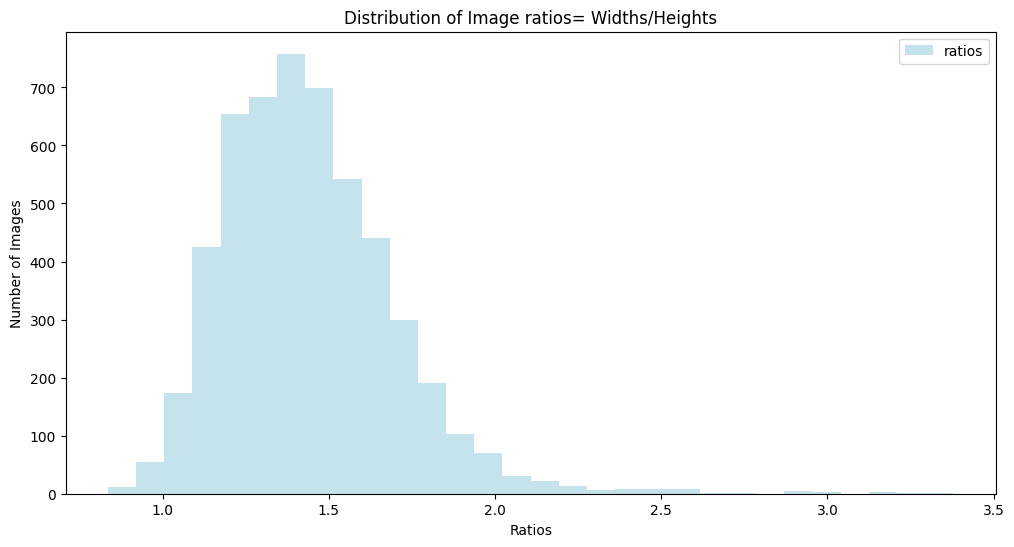

In [96]:
### Filter images given ratios(option 3)
## Plot the distribution of sizes to get an idea of the variation in the image sizes

image_sizes = [] # List to store sizes
# Loop through the training set and get the sizes
for img, label in trainset:
    # Append each size to the list
    image_sizes.append(img.size)  # img.size returns a tuple (width, height)

# widths = [size[0] for size in image_sizes]
# heights = [size[1] for size in image_sizes]
ratios = [size[0] / size[1] for size in image_sizes]

# Plot histogram of ratios
plt.figure(figsize=(12, 6))
plt.hist(ratios, bins=30, alpha=0.7, color='lightblue', label='ratios')
plt.title('Distribution of Image ratios= Widths/Heights')
plt.xlabel('Ratios')
plt.ylabel('Number of Images')
plt.legend()
plt.savefig(save_dir + 'Distribution_ratios.png')
plt.show()

We can see that the distribution of ratios is approximatley centered around 1.5.
We remove the images with a ratio higher that 2.
This way when applying resizing, we can keep the mean ratio and avoid too big distorsions.

In [21]:
# Filter data by discarding the images with a ratio higher than 2
# Create a new directory for the filtered dataset
filtered_train_dir = os.path.join(data_dir, 'filtered_train')
os.makedirs(filtered_train_dir, exist_ok=True)

# Copying images that meet the criteria
for idx, (img, label) in enumerate(trainset):
    if img.size[0]/img.size[1] <= 2:
        class_name = trainset.classes[label]
        class_dir = os.path.join(filtered_train_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        img_path = trainset.imgs[idx][0]  # Original path of the image
        img_filename = os.path.basename(img_path)
        img.save(os.path.join(class_dir, img_filename))

filtered_trainset = datasets.ImageFolder(filtered_train_dir)


In [28]:
### Data Augmentation (option 4)
## Apply data augmentation to the images in the training set to increase the diversity of the dataset and cope with the imbalanced class problem (and create a new dataset with augmented images in perfect balance classes)


def augmentation(dataset, data_dir):
    """
    Applies image augmentations selectively and saves the augmented and certain original images.
    
    Args:
        dataset: ImageFolder dataset instance.
        data_dir (str): Base directory where augmented and selective original images will be stored.
        
    """
    # Setup directories for augmented and original images
    path_augmented_folder = os.path.join(data_dir, 'augmented_images', 'train')
    if not os.path.exists(path_augmented_folder):
        os.makedirs(path_augmented_folder, exist_ok=True)

    # Augmentation pipeline
    augment= iaa.Sequential([
        iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=0.05 * 255)),
        iaa.Sometimes(0.5, iaa.ElasticTransformation(alpha=1, sigma=0.1)),
        iaa.Sometimes(0.5, iaa.Cutout(nb_iterations=2, size=0.2))
    ])

    # Determine pneumonia images to augment times_to_augment a single normal image
    pneumonia_paths = [path for path, label in dataset.samples if label == 1]
    normal_paths = [path for path, label in dataset.samples if label == 0]
    print(f"Number of pneumonia images: {len(pneumonia_paths)}")
    print(f"Number of normal images: {len(normal_paths)}")
    num_to_augment = len(pneumonia_paths)-len(normal_paths)
    print(f"Number of augmented image: {num_to_augment}")
    times_to_augment = num_to_augment // len(normal_paths)
    print(f"Number of times to augment each normal image: {times_to_augment}")
    
    random.shuffle(pneumonia_paths)
    pneumonia_augment_paths = pneumonia_paths[:num_to_augment]
    pneumonia_keep_paths = pneumonia_paths[num_to_augment:]

    nb_normal_augmented = 0

    for img_path, label in dataset.samples:
        image = Image.open(img_path)
        image_np = np.array(image)
        new_filename = Path(img_path).name
        class_label = dataset.classes[label]
        
        original_path = os.path.join(path_augmented_folder, class_label, new_filename)

        if img_path in pneumonia_augment_paths:
            # Augment this image
            image_aug = augment(image=image_np)
            image_aug = Image.fromarray(image_aug)
            augmented_path = os.path.join(path_augmented_folder, class_label, 'augmented_' + new_filename)
            os.makedirs(os.path.dirname(augmented_path), exist_ok=True)
            image_aug.save(augmented_path)
        if label == 0 :
            # Augment this image times_to_augment times to balance the dataset
            for i in range(times_to_augment+1):
                if nb_normal_augmented >= num_to_augment:
                    break
                image_aug = augment(image=image_np)
                image_aug = Image.fromarray(image_aug)
                augmented_path = os.path.join(path_augmented_folder, class_label, 'augmented_'+ f'_{i}'+ new_filename )
                os.makedirs(os.path.dirname(augmented_path), exist_ok=True)
                image_aug.save(augmented_path)
                nb_normal_augmented += 1

        # Save original images too for normal cases and pneumonia cases that were not augmented to obtain a balanced dataset
        if label == 0 or img_path in pneumonia_keep_paths:
            os.makedirs(os.path.dirname(original_path), exist_ok=True)
            image.save(original_path)
    print(f"Number of augmented normal images: {nb_normal_augmented}")


# Apply the augmentation
augmentation(filtered_trainset, data_dir)

Number of pneumonia images: 3759
Number of normal images: 1341
Number of augmented image: 2418
Number of times to augment each normal image: 1
Number of augmented normal images: 2418


In [29]:
### Resizing and Normalizing the images (option 5 and 6)
## Normalize the images to have a mean of 0 and a standard deviation of 1

# calculate the mean and the standard deviation of the images in the training set.
def get_mean_std(loader):
    num_pixels = 0
    mean = 0.0
    std = 0.0

    for images, _ in loader:
        # Flatten height and width dimensions
        images = images.view(images.size(0), images.size(1), -1)

        # Compute mean and std
        mean += images.mean(dim=2).sum(0)
        std += images.std(dim=2).sum(0)

        num_pixels += images.size(0) * images.size(2)

    mean /= num_pixels
    std /= num_pixels

    return mean, std


# Create a DataLoader for the training set
    ### Resizing the images (option 5)
resizing = T.Compose([T.Resize((200, 300)), T.Grayscale(num_output_channels=1), T.ToTensor()])
resized_trainset = datasets.ImageFolder(os.path.join(data_dir, 'augmented_images', 'train'), transform=resizing)

batch_size = 32
loader_train = DataLoader(resized_trainset, batch_size=batch_size, shuffle=True)

# Get the length of the dataset
dataset_length = len(loader_train.dataset)

# Generate n random indices
n = 200
indices = torch.randperm(dataset_length)[:n]

# Create a SubsetRandomSampler using the random indices
sampler = SubsetRandomSampler(indices)

# Create a new DataLoader with the SubsetRandomSampler
small_loader_train = DataLoader(
    dataset=loader_train.dataset,
    batch_size=1,
    sampler=sampler,
)

mean_train, std_train = get_mean_std(small_loader_train)
print(f"Mean: {mean_train}")
print(f"Standard Deviation: {std_train}")

## Assuming that the scans have the same magnification, we can resize the images to a fixed size (keeping the a ratio 1.5) without distorting the aspect too much (assuming a constant magnification)

#transform the data accordingly 

resize_normalize = T.Compose([T.Resize((200, 300)),
                              T.Grayscale(num_output_channels=1),
                              T.ToTensor(),
                              T.Normalize(mean_train, std_train)                             
                             ])

trainset_preprocessed= datasets.ImageFolder(os.path.join(data_dir, 'augmented_images', 'train'), transform=resize_normalize)
testset_preprocessed= datasets.ImageFolder(os.path.join(data_dir, "test"), transform=resize_normalize)
validset_preprocessed= datasets.ImageFolder(os.path.join(data_dir, "val"), transform=resize_normalize)




Mean: tensor([7.9740e-06])
Standard Deviation: tensor([3.7491e-06])


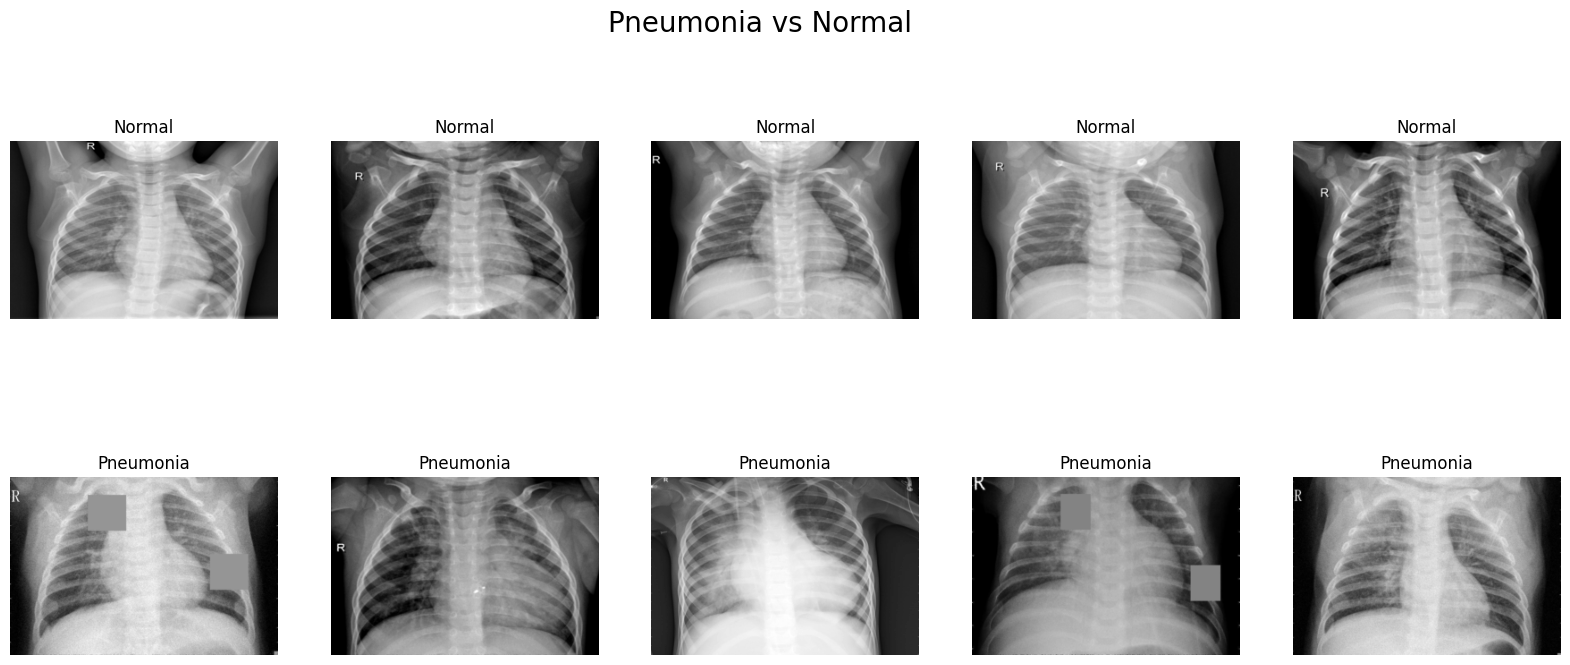

In [30]:
#Visualize 5 examples of images of each class after preprocessing 

#Save the examples for future use
normal_indices = [i for i, x in enumerate(trainset_preprocessed.targets) if x == 0]
pneumonia_indices = [i for i, x in enumerate(trainset_preprocessed.targets) if x == 1]

Exset_normal = [trainset_preprocessed[i] for i in normal_indices[:5]]
Exset_pneumonia = [trainset_preprocessed[i] for i in pneumonia_indices[:5]]

#Plot the examples
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Pneumonia vs Normal', fontsize=20)

for i in range(5):
    # For Normal 
    image_normal = Exset_normal[i][0]
    ax[0, i].imshow(image_normal[0], cmap='gray')
    ax[0, i].set_title('Normal')
    ax[0, i].axis('off')
    
    # For Pneumonia
    image_pneumonia = Exset_pneumonia[i][0]
    ax[1, i].imshow(image_pneumonia[0], cmap='gray')
    ax[1, i].set_title('Pneumonia')
    ax[1, i].axis('off')

plt.show()



In [31]:
# Get the label distribution of the preprocessed training set
train_labels = [x[1] for x in trainset_preprocessed]
train_labels_count = pd.Series(train_labels).value_counts().sort_index()

print("TRAIN LABELS:")
print(
    "# of Normal cases: ",
    train_labels_count[0],
    " # of Pneumonia cases: ",
    train_labels_count[1]
)


TRAIN LABELS:
# of Normal cases:  3759  # of Pneumonia cases:  3759


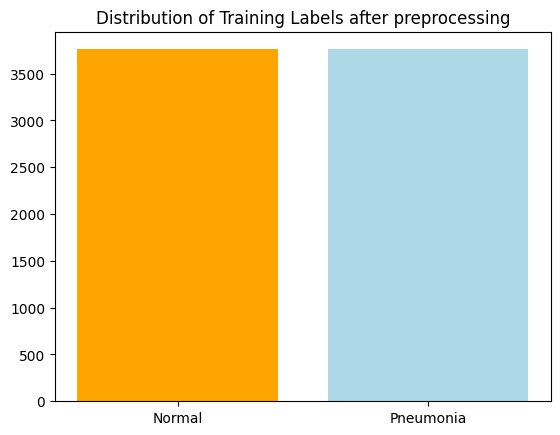

In [32]:
# Plotting the labels distribution as a bar chart
plt.bar(['Normal', 'Pneumonia'], [train_labels_count[0], train_labels_count[1]], color=['orange','lightblue'])
plt.title('Distribution of Training Labels after preprocessing')
plt.show()

In [33]:

# Create a DataLoader for each dataset
batch_size = 128
loader_train = DataLoader(trainset_preprocessed, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(testset_preprocessed, batch_size=batch_size, shuffle=False)
loader_valid = DataLoader(validset_preprocessed, batch_size=batch_size, shuffle=False)


## Q2) CNN Classifier

### Q2.1: Create the CNN model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * (200//2**7) * (300//2**7), 256)
        self.fc2 = nn.Linear(256, 1)
  


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Check for GPU availability
device = "mps"

model = CNN().to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
# Define the CNN model for an imput image of size 200x300
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)      
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 128, 3, padding=1)


        self.batchnorm1 = nn.BatchNorm2d(8)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.batchnorm4 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.1)

        self.pool = nn.MaxPool2d(2, 2)

        # Adjusted the fully connected layer input size to match the flattened feature size
        self.fc1 = nn.Linear(128 * (300 // 2**4) * (200 // 2**4), 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.dropout(x)

        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.dropout(x)

        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.dropout(x)

        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = self.dropout(x)

        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Check for GPU availability
device = 'mps'

model = CNN().to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [81]:
# train the model
def train(model, criterion, optimizer, train_loader, valid_loader, epochs=5, plot = True):
    '''
    Train the network and validate it at each epoch plotting the training and validation loss curves
    '''
    train_losses = []
    valid_losses = []


    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            #print(images.shape)
            #print(labels.shape)
            optimizer.zero_grad()
            output = model(images)
            output = output.squeeze()
            labels = labels.float()
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                output = output.squeeze()
                labels = labels.float()
                loss = criterion(output, labels)
                valid_loss += loss.item()

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        print(f"Epoch {epoch + 1}/{epochs}.. "
              f"Train loss: {train_loss:.3f}.. "
              f"Valid loss: {valid_loss:.3f}")

    if plot:
        plt.plot(train_losses, label='Training loss')
        plt.plot(valid_losses, label='Validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return train_losses, valid_losses


train_losses, valid_losses = train(model, criterion, optimizer, loader_train, loader_valid, epochs=5)

In [35]:
# Evaluate the model on the test set

def evaluate(model, test_loader):
    '''
    Evaluate the model on the test set
    '''
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            output = output.squeeze()
            labels = labels.float()
            loss = criterion(output, labels)
            test_loss += loss.item()
            preds = torch.round(torch.sigmoid(output))
            correct += (preds == labels).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)

    print(f"Test loss: {test_loss:.3f}.. "
          f"Test accuracy: {accuracy:.3f}")
    
    return test_loss, accuracy


test_loss, test_accuracy = evaluate(model, loader_test)

Test loss: 1.525.. Test accuracy: 0.768


In [2]:
def eval_model(model, loader, criterion):
    """
    The function calculates various evaluation metrics such as accuracy, F1 score, precision, and recall, and generates a confusion matrix heatmap.
     
    Args:
    model: the trained PyTorch model to evaluate
    loader: the PyTorch DataLoader object containing the data to evaluate the model on 
    criterion: the loss function used to evaluate the model

    """
    # Evaluate model on the loader set (validation or test set)
    model.eval()
    _loss = 0.0
    _accuracy = 0.0
    predicted = []
    labels_array = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.squeeze()
            labels = labels.float()
            loss = criterion(outputs, labels)
            _loss += loss.item() * images.size(0)
            
            for label in labels:
                labels_array.append(int(label.item()))

            for output in outputs:
                if output.item()> 0.5:
                    predicted.append(1)

                else:
                    predicted.append(0)

            my_labels = labels.tolist()
            for i in range(0,len(my_labels)):
                if (predicted[i] == labels[i]):
                    _accuracy=_accuracy+1

        _acc = accuracy_score(labels_array,predicted)
        print('Accuracy: %.3f' % _acc)
        _F1 = f1_score(labels_array,predicted)
        print('F1 score: %.3f' % _F1)
        _precision = precision_score(labels_array,predicted)
        print('Precision score: %.3f' % _precision)
        _recall = recall_score(labels_array,predicted)
        print('Recall score: %.3f' % _recall)
        _cm = confusion_matrix(labels_array,predicted)        
        
        
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ['{0:0.0f}'.format(value) for value in
                        _cm.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in
                            _cm.flatten()/np.sum(_cm)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
                zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(_cm, annot=labels, fmt="", cmap='Blues')
        plt.savefig(save_dir + 'confusion_matrix.png')




In [3]:
eval_model(model, loader_valid, criterion)

NameError: name 'model' is not defined

Accuracy: 0.779
F1 score: 0.847
Precision score: 0.745
Recall score: 0.982


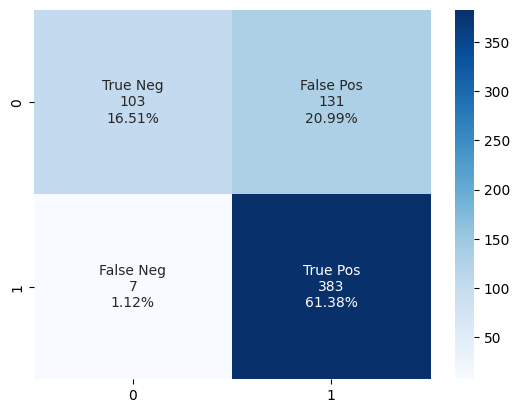

In [47]:
eval_model(model, loader_test, criterion)


In [66]:
# Q3 calculate integrated gradients 

# normal_indices = [i for i, x in enumerate(testset_preprocessed.targets) if x == 0]
# pneumonia_indices = [i for i, x in enumerate(testset_preprocessed.targets) if x == 1]

# Ex_normal = [testset_preprocessed[i] for i in normal_indices[:5]]
# Ex_pneumonia = [testset_preprocessed[i] for i in pneumonia_indices[:5]]

normal_paths = [path for path, label in testset_preprocessed.samples if label == 0]
pneumonia_paths = [path for path, label in testset_preprocessed.samples if label == 1]

In [6]:
#upload the model from path 

path_to_model = '/Users/akilabeddiaf/Documents/Sophia/ETHZ/CBB/S2/ML4H/Project_1/pneumonia_prediction/Q3/model.pth'


model = torch.load(path_to_model)

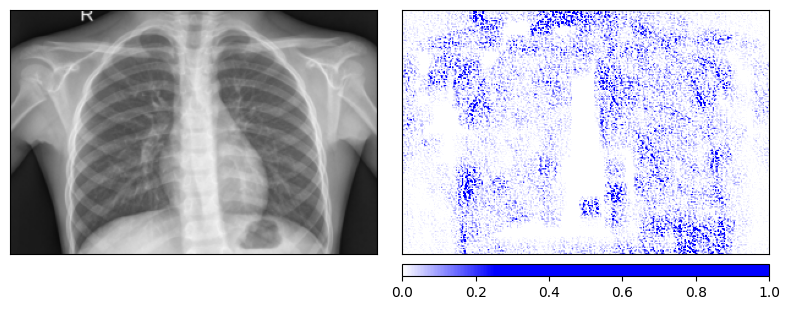

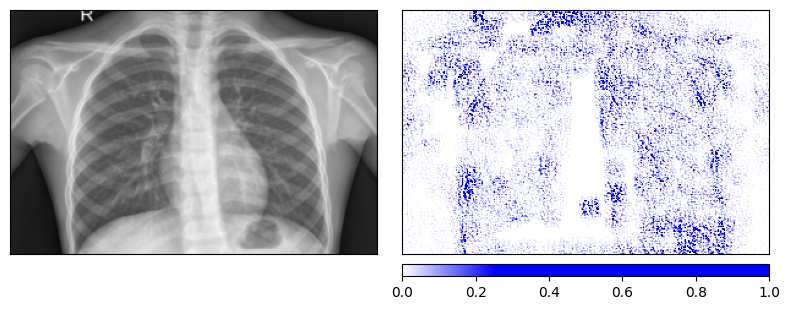

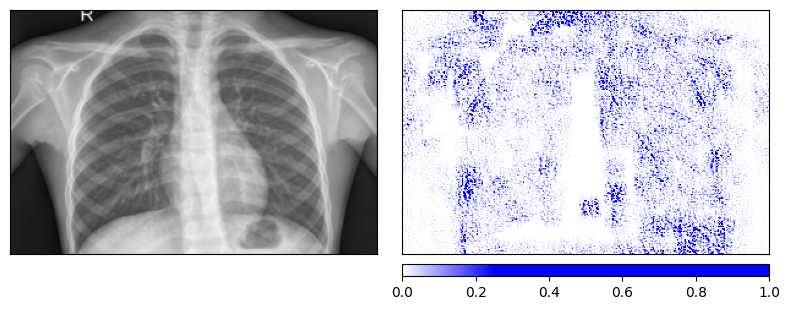

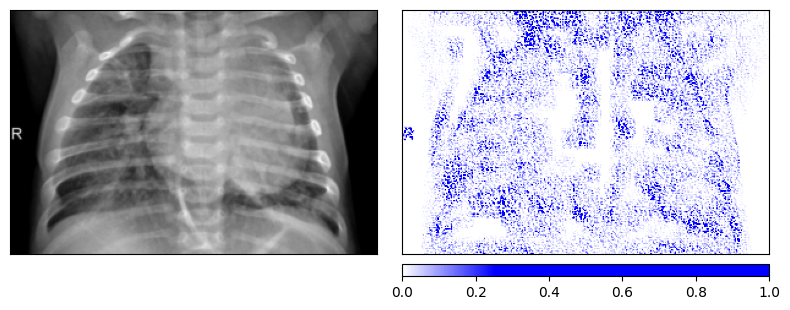

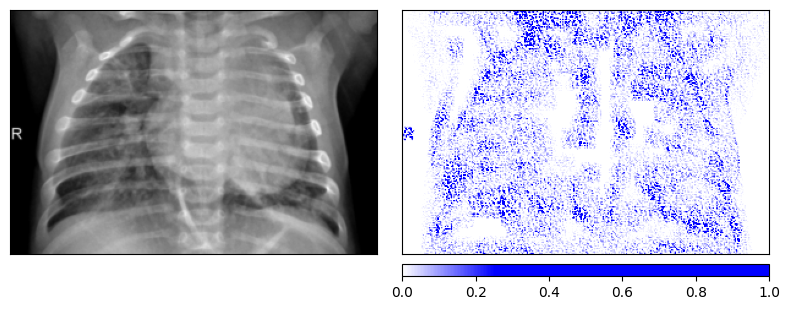

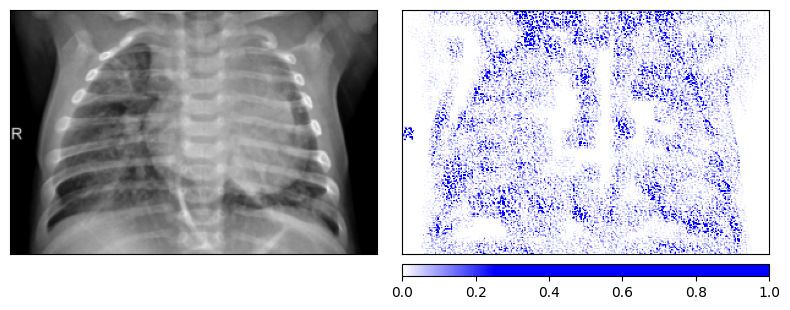

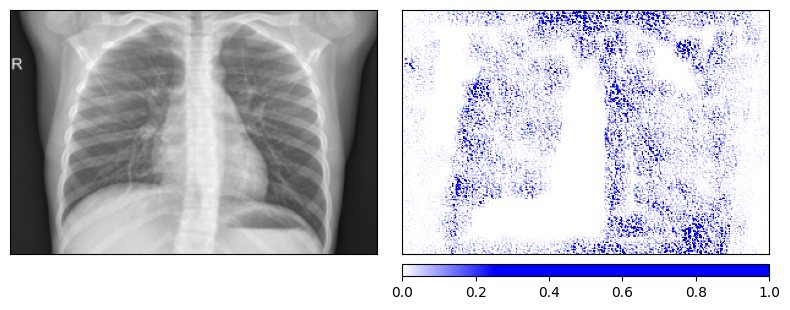

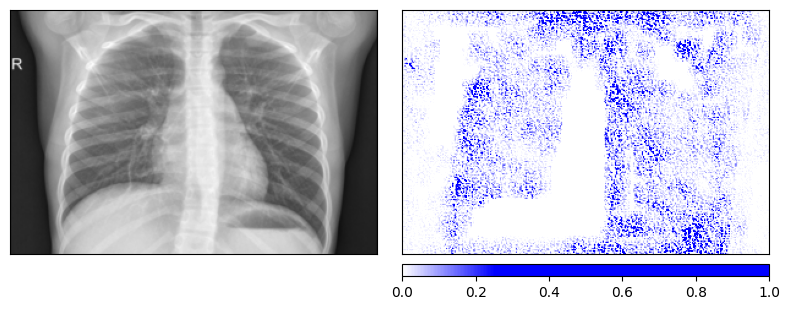

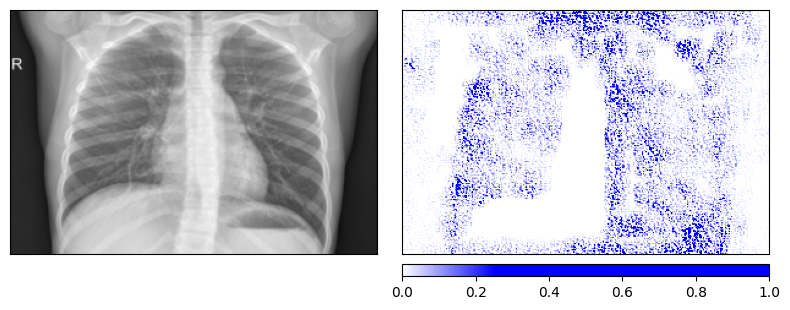

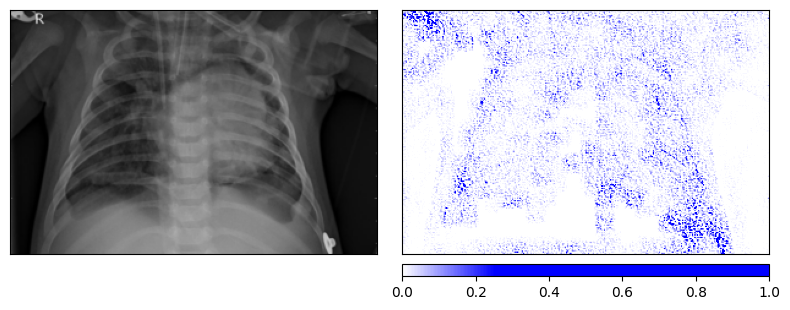

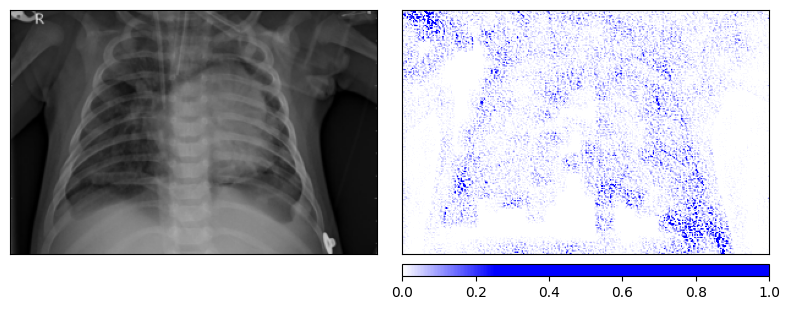

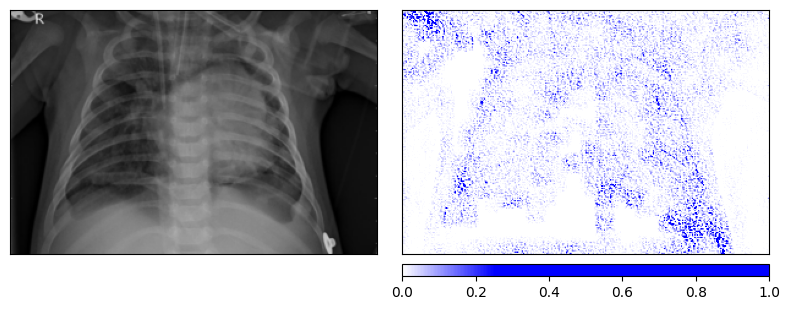

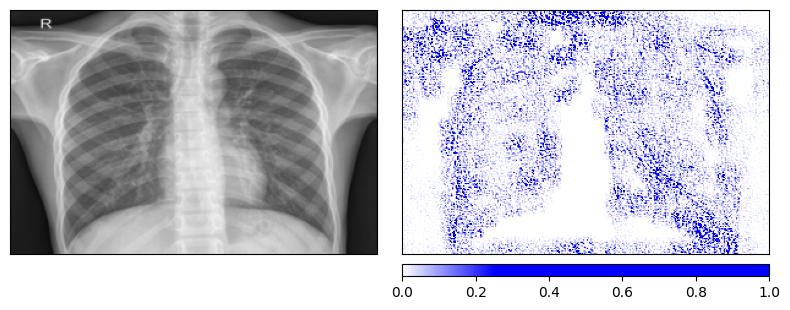

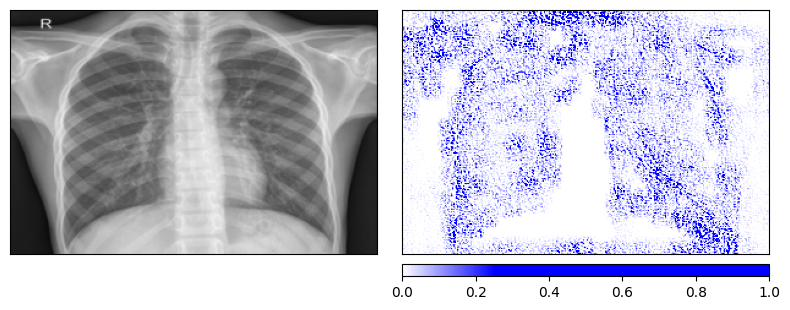

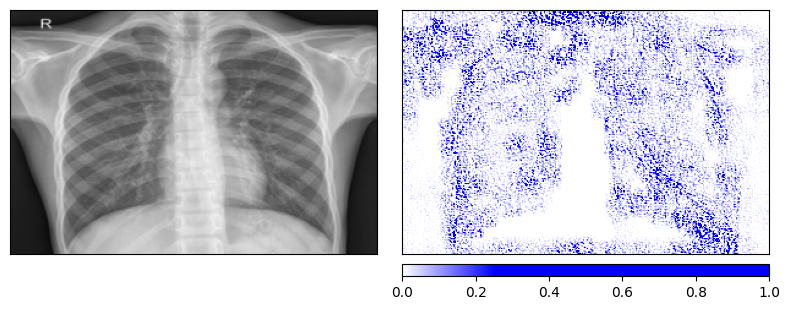

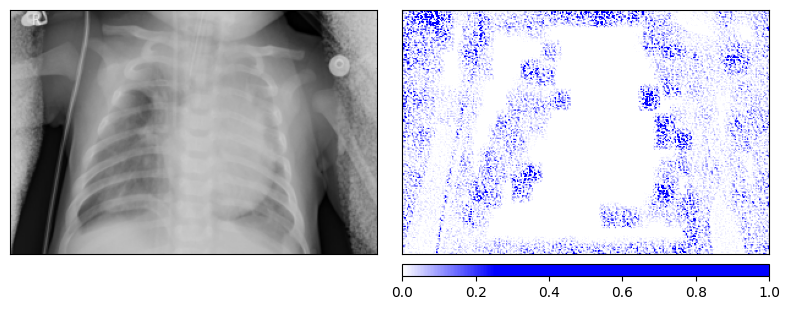

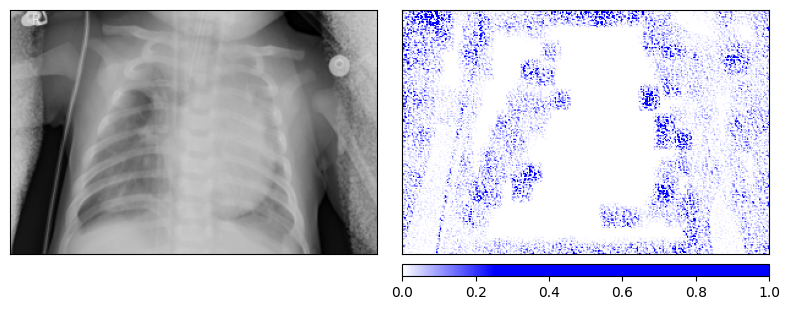

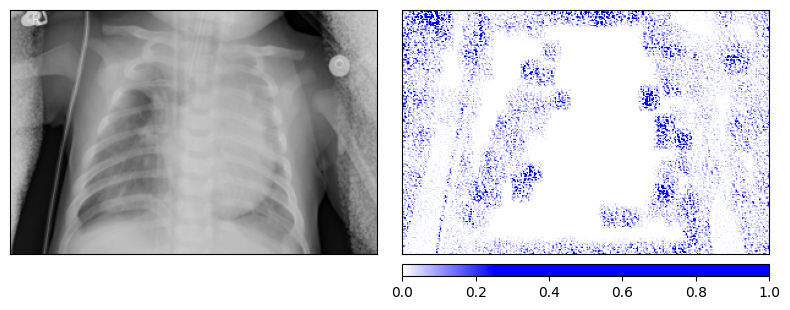

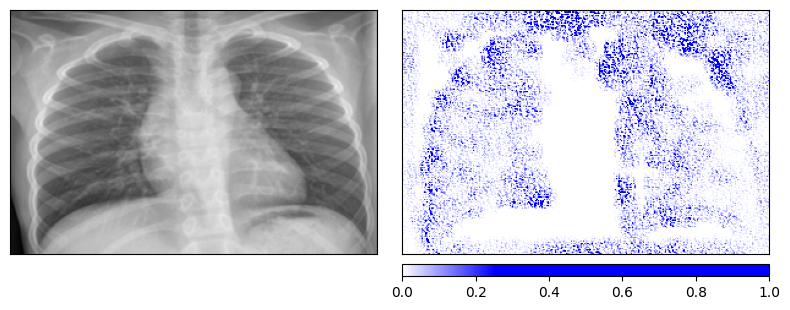

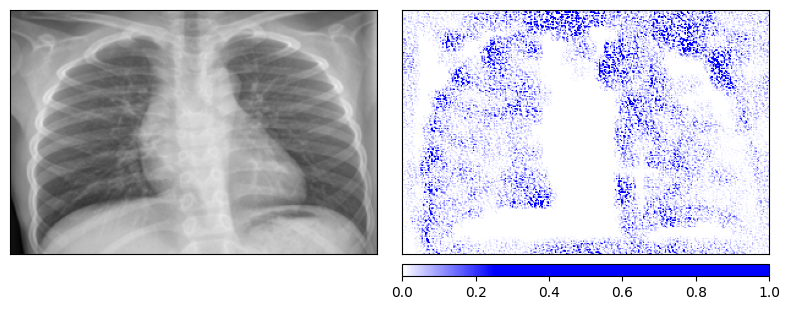

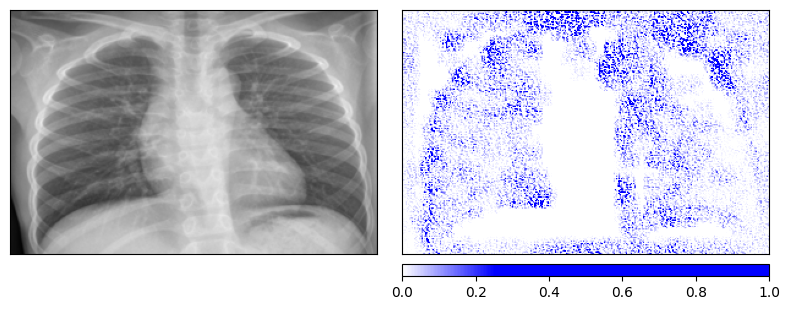

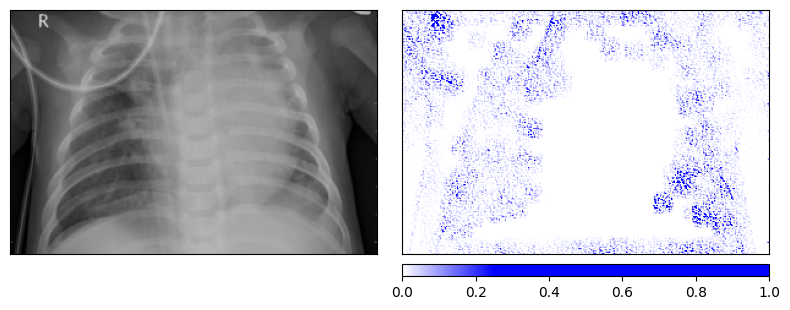

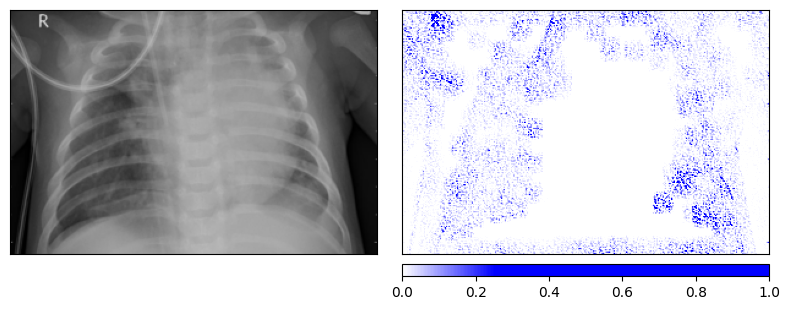

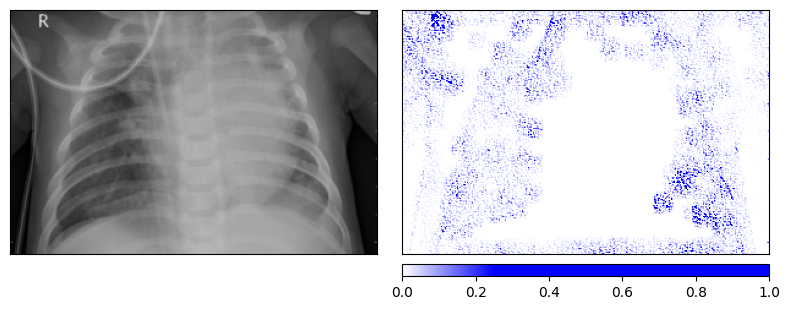

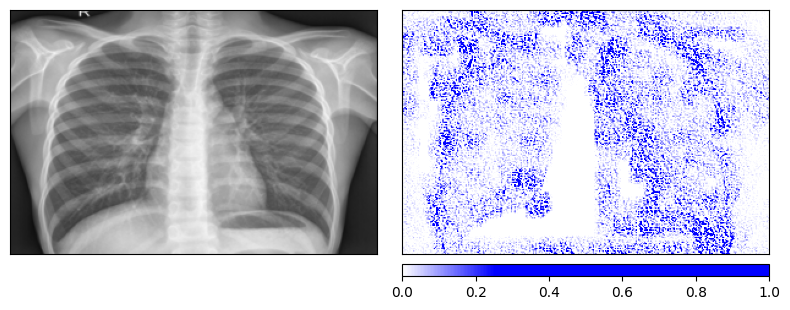

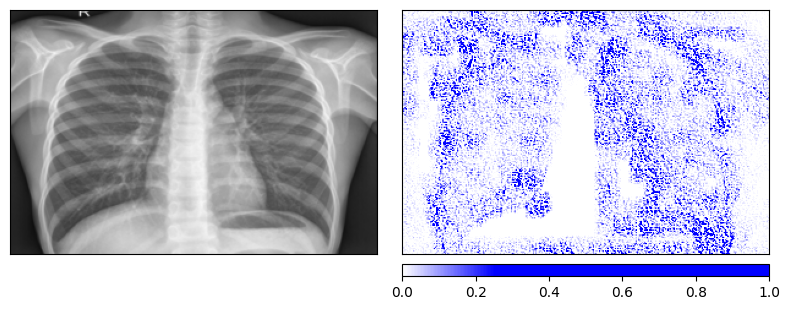

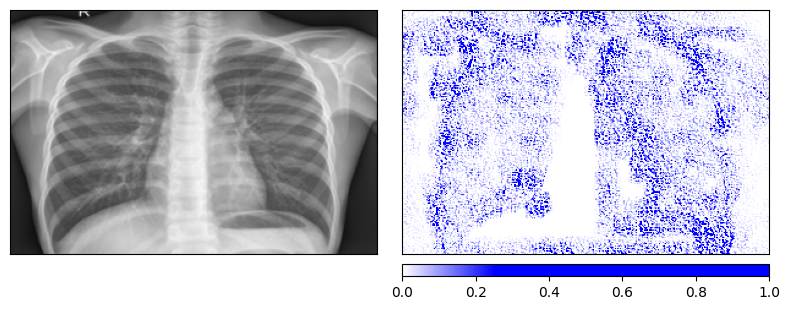

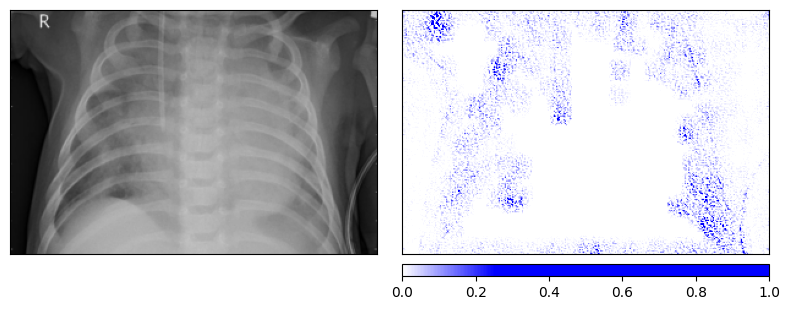

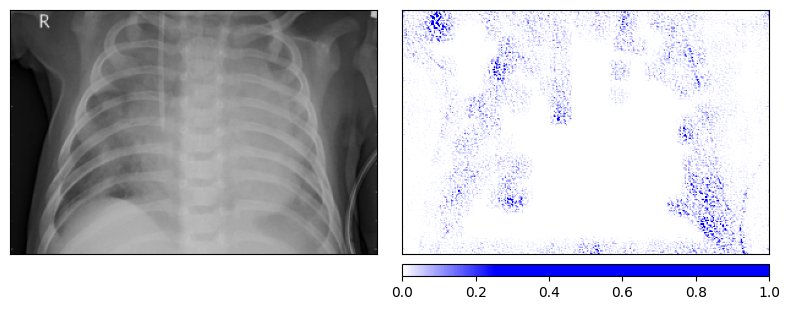

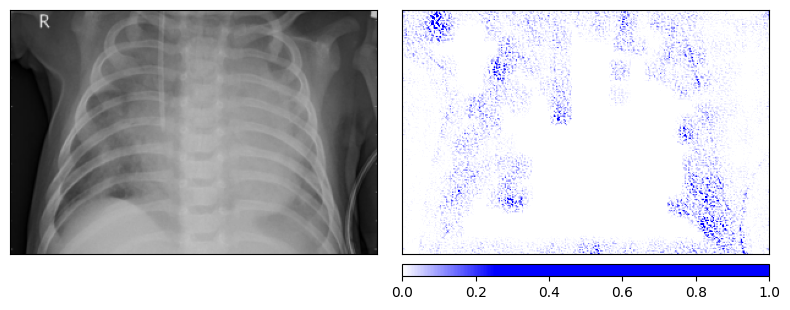

In [75]:
def calculate_integrated_gradients(img_path, model, result_path, baseline_type='zero'):
    img=Image.open(img_path)
    
    transform_plot = T.Compose([T.Resize((200, 300)), T.Grayscale(num_output_channels=1), T.ToTensor()])
    transformed_img = transform_plot(img)
    #print("transformed_img dim", transformed_img.size())
    
    transform_input = T.Compose([T.Resize((200, 300)), T.Grayscale(num_output_channels=1), T.ToTensor(), T.Normalize(mean_train, std_train)])
    input= transform_input(img)
    input = input.unsqueeze(0) #add a dimnesion for the steps
    #print("input dim", input.size())
    model.eval()
    model.to('cpu')

    # Select baseline based on type
    if baseline_type == 'zero':
        baseline = torch.zeros_like(input)
    elif baseline_type == 'random':
        baseline = torch.rand_like(input)  # Random noise baseline
    elif baseline_type == 'mean':
        baseline = torch.full_like(input, 0.5)  # Mid-value baseline

    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input, baselines=baseline, target=0, n_steps=75)

    
    default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                         [(0, '#ffffff'),
                                                          (0.25, '#0000ff'),
                                                          (1, '#0000ff')], N=256)

    np_attributions_ig=attributions_ig.squeeze(0).cpu().detach().numpy()
    np_transformed_img=transformed_img.cpu().detach().numpy()
    #print(np_attributions_ig.shape)
    #print(np_transformed_img.shape)
    attributions_ig_3d = np.repeat(np_attributions_ig, 3, axis=0)
    transformed_img_3d = np.repeat(np_transformed_img, 3, axis=0)
    #print(attributions_ig_3d.shape)
    #print(transformed_img_3d.shape)

    fig, ax = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_3d, (1, 2, 0)),
                                              np.transpose(transformed_img_3d, (1, 2, 0)),
                                              ["original_image", "heat_map"],
                                              ["all", "positive"],
                                              cmap=default_cmap,
                                              show_colorbar=True)
    fig.savefig(result_path)

baselines = ['zero', 'random', 'mean']
for i in range(5):
    for baseline in baselines:
        #  For Normal
        calculate_integrated_gradients(normal_paths[i], model, f'/Users/akilabeddiaf/Documents/Sophia/ETHZ/CBB/S2/ML4H/Project_1/pneumonia_prediction/Q3/normal-attributionmap{i}_{baseline}.png', baseline_type= baseline)
    for baseline in baselines:
        # For Pneumonia
        calculate_integrated_gradients(pneumonia_paths[i], model, f'/Users/akilabeddiaf/Documents/Sophia/ETHZ/CBB/S2/ML4H/Project_1/pneumonia_prediction/Q3/pneumonia-attributionmap{i}_{baseline}.png', baseline_type= baseline)


In [55]:
torch.save(model, '/Users/akilabeddiaf/Documents/Sophia/ETHZ/CBB/S2/ML4H/Project_1/pneumonia_prediction/Q3/model.pth')

## Q5) Data Randomization Test

In [79]:
#create a new dataset with randomized labels

from torch.utils.data import Dataset

class RandomizedLabelDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = torch.randperm(len(dataset.targets))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, _ = self.dataset[idx]
        label = self.labels[idx]
        return data, label

# Apply the randomized label dataset wrapper
randomized_trainset = RandomizedLabelDataset(trainset_preprocessed)
loader_train_randomized = DataLoader(randomized_trainset, batch_size=batch_size, shuffle=True)


In [88]:
count=0
for i in range(len(trainset_preprocessed[0])):
    if trainset_preprocessed[i][1] != randomized_trainset[i][1]:
        count = count+1
p = count/(len(trainset_preprocessed[0]))*100

print('Percentage of modified labels: %.3f' % p)

Percentage of modified labels: 100.000
